# Reranker Models Evaluation

In [24]:
import os
import json
import pandas as pd
import datetime
from typing import List, Dict, Set, Optional
import torch
import gc
import re


from sentence_transformers import SentenceTransformer, CrossEncoder
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.embeddings.base import Embeddings


import logging

# Set this flag to False when you don't want to log to a file
ENABLE_FILE_LOGGING = True

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_file_path = f"../../data/pipeline2/rerank_eval/reranker_eval_res_{timestamp}.txt"

# Create logger
logger = logging.getLogger("reranker_logger")
if logger.hasHandlers():
    logger.handlers.clear()
logger.setLevel(logging.DEBUG)

# Formatter that outputs only the message text
formatter = logging.Formatter("%(message)s")

# Always add the console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# Conditionally add file handler
if ENABLE_FILE_LOGGING:
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)


class CustomSentenceTransformerEmbeddings(Embeddings):
    """
    Allows using a SentenceTransformer model within a LangChain-based FAISS store.
    Handles initialization of different models with specific arguments.
    """

    def __init__(self, embedding_model_name: str):
        self.embedding_model_name = embedding_model_name
        self.model = self._initialize_model()

    def _initialize_model(self) -> SentenceTransformer:
        """
        Initializes the SentenceTransformer model based on the embedding_model_name.
        """
        model_configs = {
            "jinaai/jina-embeddings-v3": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"use_flash_attn": False},
            },
            "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": {
                "local_files_only": True,
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
            "Alibaba-NLP/gte-large-en-v1.5": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
        }

        config = model_configs.get(
            self.embedding_model_name,
            {"device": "cuda", "model_kwargs": {}},  # default fallback
        )

        try:
            model = SentenceTransformer(self.embedding_model_name, **config)
            logger.info(
                f"Initialized SentenceTransformer model: {self.embedding_model_name}"
            )
            return model
        except Exception as e:
            logger.info(f"Error initializing model {self.embedding_model_name}: {e}")
            raise

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode(text).tolist()

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts).tolist()

    def unload_model(self):
        """
        Remove the model from memory after processing to free up GPU resources.
        """
        if self.model:
            del self.model
            self.model = None
            torch.cuda.empty_cache()
            gc.collect()
            logger.info(f"Unloaded embedding model: {self.embedding_model_name}")
        else:
            logger.debug("[DEBUG] Embedding model was already None or not set.")


class Reranker:
    """
    A reranker that uses a CrossEncoder to score (query, doc) pairs and reorder them.
    """

    def __init__(self, reranker_model_name: str):
        self.reranker_model_name = reranker_model_name
        # Refactor Note:
        #   Using cross-encoder with trust_remote_code, device=cuda, etc.
        self.reranker = CrossEncoder(
            reranker_model_name,
            automodel_args={"torch_dtype": "auto", "attn_implementation": "eager"},
            trust_remote_code=True,
            device="cuda",
            revision="main",
        )
        logger.info(f"Loaded reranker model: {reranker_model_name}")

    def rerank(
        self, query: str, documents: List[str], top_n: Optional[int] = None
    ) -> List[Dict]:
        """
        Return a list of dicts: [
          {"text": doc_text, "score": float, "rank": int}, ...
        ],
        sorted descending by score. If top_n is given, truncate the list.
        """
        if not documents:
            return []
        pairs = [[query, doc] for doc in documents]
        scores = self.reranker.predict(pairs)  # shape: [num_docs]

        # Sort by descending score
        doc_score_pairs = sorted(
            zip(documents, scores), key=lambda x: x[1], reverse=True
        )
        results = []
        for i, (text, score) in enumerate(doc_score_pairs):
            results.append({"text": text, "score": float(score), "rank": i + 1})

        if top_n is not None:
            results = results[:top_n]
        return results

    def evaluate_rerank(
        self,
        expected_chunk: str,
        reranked_results: List[Dict],
    ) -> Dict:
        """
        Evaluate how well the reranker found the `expected_chunk`.
        Return:
          {
            "found": bool,
            "rank": int or None,
            "mrr": float
          }
        """
        target_prefix = expected_chunk.strip()
        found_rank = None

        for item in reranked_results:
            item_text = strip_content_between_dashes(item["text"])
            doc_prefix = item_text.strip()
            if doc_prefix == target_prefix:
                found_rank = item["rank"]
                break

        if found_rank is None:
            return {"found": False, "rank": None, "mrr": 0.0}
        else:
            return {"found": True, "rank": found_rank, "mrr": 1.0 / found_rank}

    def unload_model(self):
        """
        Remove the cross-encoder model from memory after processing to free GPU resources.
        """
        if self.reranker:
            del self.reranker
            self.reranker = None
            torch.cuda.empty_cache()
            gc.collect()
            logger.info(f"Unloaded reranker model: {self.reranker_model_name}")
        else:
            logger.info("[DEBUG] Reranker model was already None or not set.")


def strip_content_between_dashes(chunk: str) -> str:
    """
    Removes content between `---` markers, inclusive, if it exists.
    """
    if "---" in chunk:
        return re.sub(r"---.*?---", "", chunk, flags=re.DOTALL).strip()
    return chunk


def evaluate_retrieval(
    retrieved_chunks: List[str],
    expected_chunks: List[str],
):
    """
    Strips `--- ... ---` from retrieved chunks, then compares
    the characters for exact match.
    Returns (correctly_retrieved, missed_chunks) sets.
    """
    processed_retrieved = [
        strip_content_between_dashes(chunk) for chunk in retrieved_chunks
    ]
    expected_prefixes = set([c.strip() for c in expected_chunks])
    retrieved_prefixes = set(
        [c.strip() for c in processed_retrieved]
    )

    correctly_retrieved = expected_prefixes.intersection(retrieved_prefixes)
    missed_chunks = expected_prefixes.difference(retrieved_prefixes)

    logger.info(f"\nExact-Match Evaluation:")
    logger.info(
        f"  Correctly retrieved: {len(correctly_retrieved)}/{len(expected_chunks)}"
    )
    for prefix in correctly_retrieved:
        logger.info(f"    ✔ {prefix}")

    logger.info(f"  Missed: {len(missed_chunks)}/{len(expected_chunks)}")
    for prefix in missed_chunks:
        logger.info(f"    ✘ {prefix}")

    return correctly_retrieved, missed_chunks


def evaluate_ranked_retrieval(
    docs_with_ranks, expected_chunks: List[str],
):
    """
    For each expected chunk, find its rank among the retrieved docs.
    Compute mean_rank, MRR, etc.
    Returns a dict with {found, missed, mean_rank, rank, mrr}.
    """
    processed_docs_with_ranks = [
        (rank, strip_content_between_dashes(doc.page_content))
        for rank, doc in docs_with_ranks
    ]
    processed_expected = [
        strip_content_between_dashes(chunk) for chunk in expected_chunks
    ]

    ranks = []
    for chunk in processed_expected:
        chunk_prefix = chunk.strip()
        matched_positions = [
            rank
            for (rank, doc) in processed_docs_with_ranks
            if doc.strip() == chunk_prefix
        ]
        ranks.append(matched_positions[0] if matched_positions else None)

    found_ranks = [r for r in ranks if r is not None]
    missed_count = sum(r is None for r in ranks)

    if found_ranks:
        if len(found_ranks) == 1:
            mean_rank = found_ranks[0]
            rank_value = int(mean_rank)
        else:
            mean_rank = sum(found_ranks) / len(found_ranks)
            rank_value = None
        mrr = sum((1.0 / r) for r in found_ranks) / len(found_ranks)
    else:
        mean_rank = None
        rank_value = None
        mrr = None

    logger.info(f"\nRanked Evaluation:")
    logger.info(f"  Found: {len(found_ranks)}/{len(expected_chunks)}")
    logger.info(f"  Missed: {missed_count}/{len(expected_chunks)}")
    if mean_rank is not None:
        logger.info(f"  Mean Rank: {mean_rank:.2f}")
    else:
        logger.info(f"  Mean Rank: N/A")
    if rank_value is not None:
        logger.info(f"  Rank: {rank_value}")
    else:
        logger.info(f"  Rank: N/A")
    if mrr is not None:
        logger.info(f"  MRR: {mrr:.3f}")
    else:
        logger.info(f"  MRR: N/A")

    return {
        "found": len(found_ranks),
        "missed": missed_count,
        "mean_rank": mean_rank,
        "rank": rank_value,
        "mrr": mrr,
    }


def build_context(reranked_results: List[Dict], threshold: float = 0.2) -> Set[str]:
    """
    Includes docs in the context whose scores are within
    `threshold` of the top doc's score.
    """
    logger.info(f"\n[build_context] threshold = {threshold}")
    if not reranked_results:
        return set()

    sorted_docs = sorted(reranked_results, key=lambda x: x["score"], reverse=True)
    top_score = sorted_docs[0]["score"]

    context_set = set()
    for item in sorted_docs:
        if (top_score - item["score"]) <= threshold:
            context_set.add(strip_content_between_dashes(item["text"]))
        else:
            break

    return context_set


def inspect_context(
    context_set: Set[str], expected_chunk: str,
) -> bool:
    """
    Checks if the expected chunk 
    is present in the given context_set.
    Returns True if found, False otherwise.
    """
    expected_prefix = expected_chunk.strip()
    for snippet in context_set:
        snippet_prefix = snippet.strip()
        if snippet_prefix == expected_prefix:
            return True
    return False


def print_reranking_debug(
    reranker_label: str,
    reranked_results: List[Dict],
    context_set: Set[str],
    top_n: int = 5,
):
    """
    Prints top N reranked docs and the context set for debugging.
    """
    logger.info(f"\n[Using Reranker: {reranker_label}]")
    logger.info(f"[Top {top_n} Reranked Docs]")
    for item in reranked_results[:top_n]:
        snippet = strip_content_between_dashes(item["text"]).replace("\n", " ")
        logger.info(f"  R{item['rank']} | Score={item['score']:.4f} | {snippet}")

    logger.info("\n[Context Set]:")
    for snippet in context_set:
        snippet_preview = snippet.replace("\n", " ")
        logger.info(f"  - {snippet_preview}")


def save_csv_rerank(evaluation_data: List[dict], output_csv_path: str):
    """
    Appends the evaluation data to a CSV. Ensures consistent columns with pipeline2 style,
    plus reranking columns.
    """
    df_eval = pd.DataFrame(evaluation_data)

    # The embedding pipeline2 columns:
    #   model, row_index, product_name, k_value, lambda_mult,
    #   retrieved_docs, found_exact, missed_exact, mean_rank, rank, mrr
    # We'll add rerank columns: rerank_found, rerank_rank, rerank_mrr,
    # and the context columns: context_threshold, context_size
    columns_order = [
        "model",
        "row_index",
        "product_name",
        "k_value",
        "retrieved_docs",
        "found_exact",
        "missed_exact",
        "mean_rank",
        "rank",
        "mrr",
        "reranker_model",
        "rerank_found",
        "rerank_rank",
        "rerank_mrr",
        "context_added",
        "context_contains_expected",
        "context_threshold",
        "total_context_size",
    ]

    df_eval = df_eval.reindex(columns=columns_order, fill_value="N/A")

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    if not os.path.exists(output_csv_path):
        df_eval.to_csv(output_csv_path, index=False, mode="w", encoding="utf-8")
    else:
        df_eval.to_csv(
            output_csv_path, index=False, mode="a", header=False, encoding="utf-8"
        )


# Main function: Compare & Evaluate with Reranking
def compare_rows_rerank(
    df: pd.DataFrame,
    bench_dict: Dict[str, str],
    embedding_model_name: str,
    reranker_model_name: str,
    vectorstore: FAISS,
    k_value: int,
    lambda_mult: float,
    context_threshold: float,
    output_csv_path: str,
    fetch_k: int = 100,
):
    """
    For each row in the DataFrame (pipeline2 structure):
      1. Construct a query from the row's columns.
      2. Retrieve docs via MMR.
      3. Evaluate retrieval (exact match, rank-based).
      4. Rerank the top results; evaluate rerank performance.
      5. Build a context (optional usage).
      6. Save all results to CSV.
    """

    # Instantiate the CrossEncoder Reranker for this model
    reranker = Reranker(reranker_model_name)

    evaluation_data = []

    for idx, row in df.iterrows():
        product_name = row["Product Name"]
        classification = row["Classification Result"]
        tech_description = row["Technology Description"]

        # Build the user query
        query_str = f"Product: {product_name}\n" f"Description: {tech_description}\n"
        if classification != "Other":
            query_str += f"Classification: {classification}\n"

        expected_chunk = bench_dict.get(product_name.lower(), "")
        if not expected_chunk:
            logger.warning(
                f"[Warning] No benchmark info for product '{product_name}'. Skipping."
            )
            continue

        logger.info(f"\n[Embedding Model: {embedding_model_name}]")
        logger.info(f"[Reranker: {reranker_model_name}]")
        logger.info(f"[Row Index: {idx}]")
        logger.info(f"Query:\n{query_str}")

        # MMR Retrieval from pipeline2 vectorstore
        retriever = vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={
                "k": k_value,
                "fetch_k": fetch_k,
                "lambda_mult": lambda_mult,
            },
        )
        retrieved_docs = retriever.invoke(query_str)
        logger.info(f"Number of retrieved documents: {len(retrieved_docs)}")

        retrieved_chunks = [doc.page_content for doc in retrieved_docs]

        # Evaluate retrieval
        found_exact, missed_chunks = evaluate_retrieval(
            retrieved_chunks, [expected_chunk],
        )

        docs_with_ranks = list(enumerate(retrieved_docs, start=1))
        rank_eval = evaluate_ranked_retrieval(
            docs_with_ranks, [expected_chunk]
        )

        # Rerank top N docs (you can choose how many to rerank)
        # top_n_for_rerank = len(retrieved_chunks)
        # Or you might want to just re-rank top 10:
        top_n_for_rerank = 10

        # We pass the raw doc strings to the reranker
        rerank_input_docs = retrieved_chunks[:top_n_for_rerank]
        reranked = reranker.rerank(query_str, rerank_input_docs, top_n=None)

        # Evaluate rerank
        rerank_eval = reranker.evaluate_rerank(
            expected_chunk, reranked
        )

        # Build context from reranked (optional usage)
        context_set = build_context(reranked, threshold=context_threshold)
        context_added = len(context_set)
        context_contains_expected = inspect_context(
            context_set, expected_chunk
        )
        total_context_size = len(context_set)

        top_retrieved_docs = retrieved_chunks[:5]
        logger.info(f"\n[Top 5 Retrieved Docs]")
        for i, doc_text in enumerate(top_retrieved_docs, start=1):
            logger.info(f"  {i}. {doc_text}")

        # Print reranking debug info
        print_reranking_debug(reranker_model_name, reranked, context_set, top_n=5)

        # Collect results
        evaluation_data.append(
            {
                "model": embedding_model_name,
                "row_index": idx,
                "product_name": product_name,
                "k_value": k_value,
                "retrieved_docs": len(retrieved_docs),
                "found_exact": len(found_exact),
                "missed_exact": len(missed_chunks),
                "mean_rank": rank_eval["mean_rank"],
                "rank": rank_eval["rank"],
                "mrr": rank_eval["mrr"],
                "reranker_model": reranker_model_name,
                "rerank_found": "Yes" if rerank_eval["found"] else "No",
                "rerank_rank": rerank_eval["rank"],
                "rerank_mrr": rerank_eval["mrr"],
                "context_added": context_added,
                "context_contains_expected": (
                    "Yes" if context_contains_expected else "No"
                ),
                "context_threshold": context_threshold,
                "total_context_size": total_context_size,
            }
        )

    # Save results
    save_csv_rerank(evaluation_data, output_csv_path)

    # Unload the reranker to free GPU memory
    reranker.unload_model()



# Load the pipeline2 CSV
summaries_path = "../../data/pipeline2/sql/filtered_epd_data_lc_classified_08.csv"
df = pd.read_csv(summaries_path)

# Load the JSON benchmark data
bench_path = "../../data/pipeline2/json/200_matched_bench_EN.json"
with open(bench_path, "r", encoding="utf-8") as f:
    bench_data = json.load(f)

# Map each "epd_name" (lowercased) to "epd_category" as the expected chunk
bench_dict = {item["epd_name"].lower(): item["epd_category"] for item in bench_data}

# Define the FAISS vectorstore paths for pipeline2
vectorstore_paths = {
    # e.g. "jinaai/jina-embeddings-v3": "../../embeddings/pipeline2/jinaai_jina-embeddings-v3/faiss_index_COS_EN",
    # "Alibaba-NLP/gte-large-en-v1.5": "../../embeddings/pipeline2/Alibaba-NLP_gte-large-en-v1.5/faiss_index_COS_EN",
    "mxbai-embed-large:latest": "../../embeddings/pipeline2/mxbai-embed-large/faiss_index_COS_EN",
}

# Define the reranker models you want to evaluate
reranker_model_names = [
    "mixedbread-ai/mxbai-rerank-large-v1",
    "jinaai/jina-reranker-v1-turbo-en",
    "BAAI/bge-reranker-large",
    "jinaai/jina-reranker-v2-base-multilingual",
    "BAAI/bge-reranker-v2-m3",
    "Alibaba-NLP/gte-multilingual-reranker-base",
]

# Hyperparameters
k_value = 50
lambda_mult = 1.0
# context_thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
context_thresholds = [0.2]

# Output CSV path
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_csv_path = (
    f"../../data/pipeline2/rerank_eval/reranker_eval_res_{timestamp}.csv"
)

# 7) Loop over embedding models
for embedding_model_name, faiss_path in vectorstore_paths.items():
    # Initialize embeddings (use either CustomSentenceTransformerEmbeddings or OllamaEmbeddings)
    if embedding_model_name in [
        "jinaai/jina-embeddings-v3",
        "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5",
        "Alibaba-NLP/gte-large-en-v1.5",
    ]:
        embeddings = CustomSentenceTransformerEmbeddings(embedding_model_name)
    else:
        embeddings = OllamaEmbeddings(model=embedding_model_name)
        logger.info(f"Initialized Ollama embedding model: {embedding_model_name}")

    # Load the FAISS vector store
    vectorstore = FAISS.load_local(
        faiss_path,
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
    )

    # Load reranker model
    for reranker_name in reranker_model_names:
        for context_threshold in context_thresholds:
            compare_rows_rerank(
                df=df,
                bench_dict=bench_dict,
                embedding_model_name=embedding_model_name,
                reranker_model_name=reranker_name,
                vectorstore=vectorstore,
                k_value=k_value,
                lambda_mult=lambda_mult,
                context_threshold=context_threshold,
                output_csv_path=output_csv_path,
                fetch_k=100,
            )

    # Unload embedding model
    if isinstance(embeddings, CustomSentenceTransformerEmbeddings):
        embeddings.unload_model()

logger.info(
    f"\n>>> All reranker evaluations completed. See CSV at {output_csv_path}."
)
logger.info(f"Log file saved to {log_file_path}.")

Initialized Ollama embedding model: mxbai-embed-large:latest
Loaded reranker model: mixedbread-ai/mxbai-rerank-large-v1

[Embedding Model: mxbai-embed-large:latest]
[Reranker: mixedbread-ai/mxbai-rerank-large-v1]
[Row Index: 0]
Query:
Product: durasein solid surface
Description: durasein solid surface product manufacturing process raw material - mixing - pouring - curing - cutting - grinding - cleaning - inspection - packaging raw materials titanium dioxide aluminum hydroxide, and polymethyl methacrylate (pmma) waste corrugated cardboard incineration, pet film sanitary landfill based on key assumptions mentioned in the epd report.

Number of retrieved documents: 50

Exact-Match Evaluation:
  Correctly retrieved: 1/1
    ✔ Plastics > Profiles > Rigid Plastic Profiles
  Missed: 0/1

Ranked Evaluation:
  Found: 1/1
  Missed: 0/1
  Mean Rank: 40.00
  Rank: 40
  MRR: 0.025

[build_context] threshold = 0.2

[Top 5 Retrieved Docs]
  1. Metals > Metal Surface Treatment and Coating > Powder Coa

## Evaluation Visualizations Reranker Models


### Threshold Plots


In [14]:
CSV_PATH = "../../data/pipeline2/rerank_eval/reranker_eval_res_20250207_184649.csv"

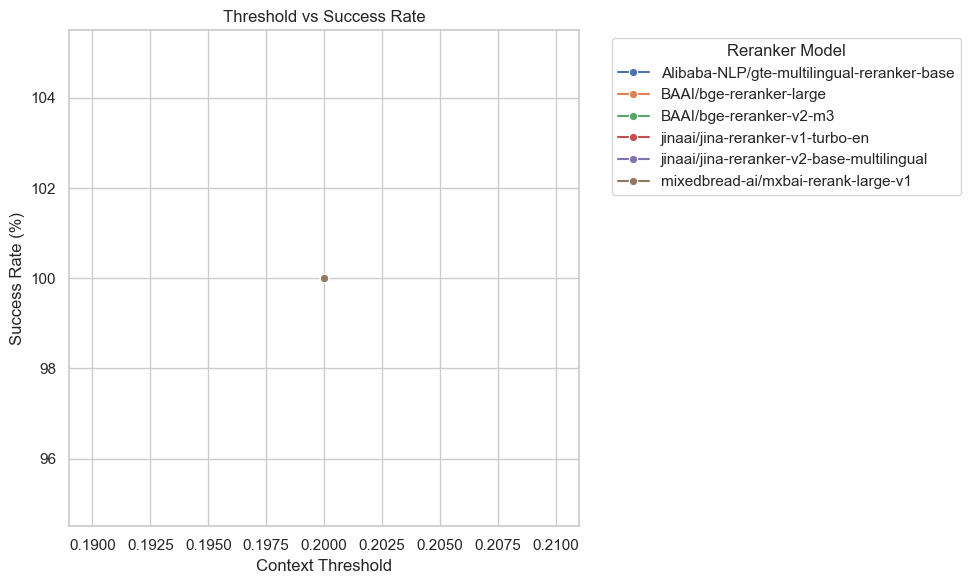


=== Threshold vs Success Rate ===
                            reranker_model  context_threshold  context_contains_expected  Success Rate (%)
Alibaba-NLP/gte-multilingual-reranker-base                0.2                        1.0             100.0
                   BAAI/bge-reranker-large                0.2                        1.0             100.0
                   BAAI/bge-reranker-v2-m3                0.2                        1.0             100.0
          jinaai/jina-reranker-v1-turbo-en                0.2                        1.0             100.0
 jinaai/jina-reranker-v2-base-multilingual                0.2                        1.0             100.0
       mixedbread-ai/mxbai-rerank-large-v1                0.2                        1.0             100.0


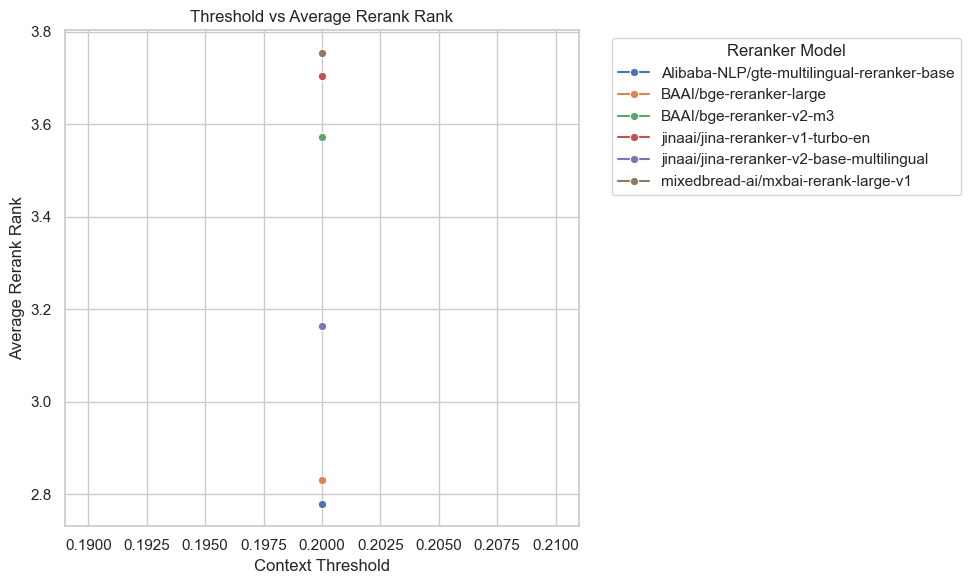


=== Threshold vs Average Rerank Rank ===
                            reranker_model  context_threshold  rerank_rank
Alibaba-NLP/gte-multilingual-reranker-base                0.2     2.779874
                   BAAI/bge-reranker-large                0.2     2.830189
                   BAAI/bge-reranker-v2-m3                0.2     3.572327
          jinaai/jina-reranker-v1-turbo-en                0.2     3.704403
 jinaai/jina-reranker-v2-base-multilingual                0.2     3.163522
       mixedbread-ai/mxbai-rerank-large-v1                0.2     3.754717


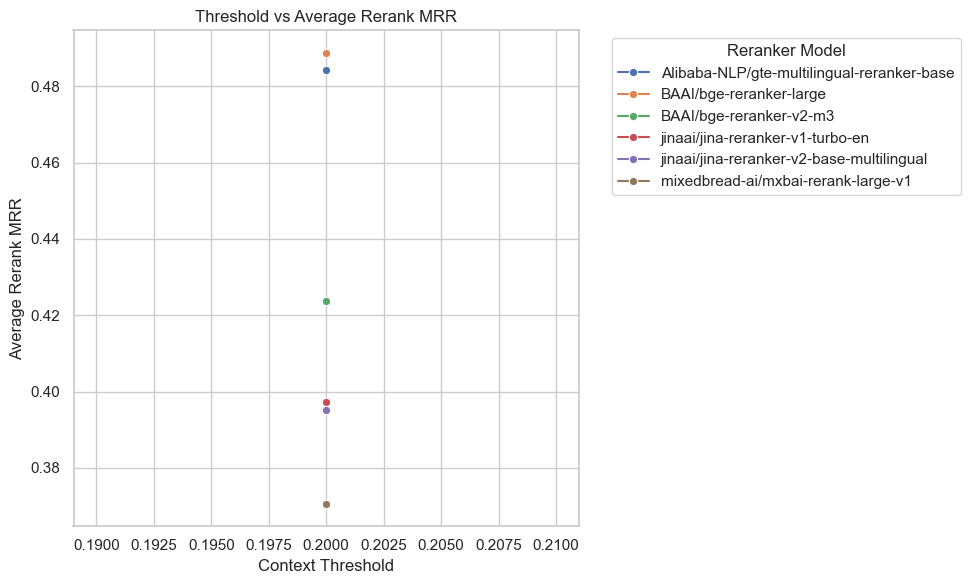


=== Threshold vs Threshold vs Average Rerank MRR ===
                            reranker_model  context_threshold  rerank_mrr
Alibaba-NLP/gte-multilingual-reranker-base                0.2    0.484214
                   BAAI/bge-reranker-large                0.2    0.488752
                   BAAI/bge-reranker-v2-m3                0.2    0.423749
          jinaai/jina-reranker-v1-turbo-en                0.2    0.397322
 jinaai/jina-reranker-v2-base-multilingual                0.2    0.395165
       mixedbread-ai/mxbai-rerank-large-v1                0.2    0.370635


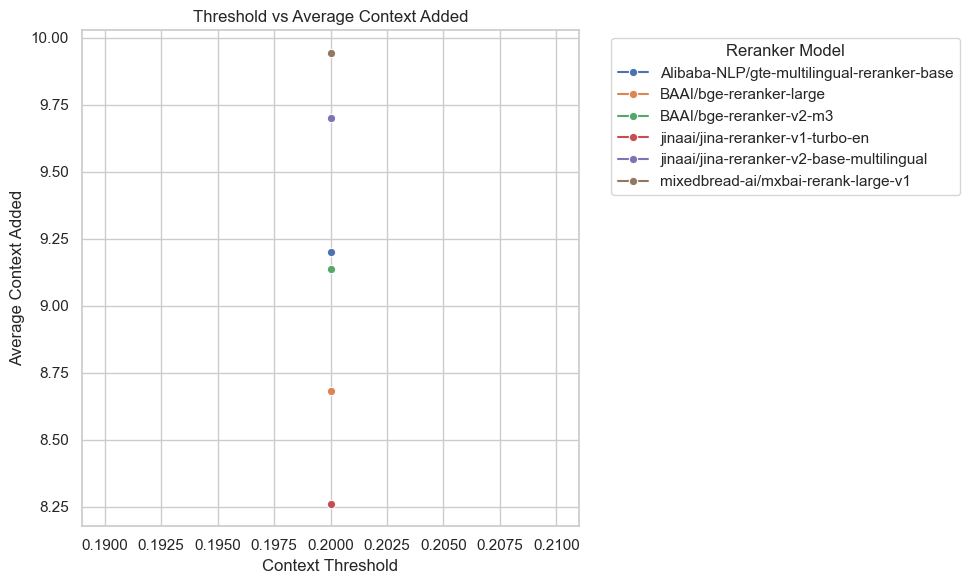


=== Threshold vs Average Context Added ===
                            reranker_model  context_threshold  context_added
Alibaba-NLP/gte-multilingual-reranker-base                0.2       9.198953
                   BAAI/bge-reranker-large                0.2       8.680628
                   BAAI/bge-reranker-v2-m3                0.2       9.136126
          jinaai/jina-reranker-v1-turbo-en                0.2       8.261780
 jinaai/jina-reranker-v2-base-multilingual                0.2       9.701571
       mixedbread-ai/mxbai-rerank-large-v1                0.2       9.942408

=== FINAL AGGREGATED SUMMARY ===
                            reranker_model  context_threshold_min  context_threshold_max  success_rate  avg_mean_rank  avg_rerank_mrr  avg_context_added  max_total_context_size  total_product_names  Success Rate (%)
Alibaba-NLP/gte-multilingual-reranker-base                    0.2                    0.2           1.0       2.779874        0.484214           9.198953               

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ========================
# 1. CONFIG & DATA LOADING
# ========================

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# ======================
# 2. DATA PREPARATION
# ======================
df["context_contains_expected"] = df["context_contains_expected"].astype(bool)

# Ensure numeric types where relevant
for col in [
    "rank",
    "rerank_rank",
    "rerank_rank",
    "mrr",
    "rerank_mrr",
    "context_threshold",
    "total_context_size",
]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing numeric values
df["rank"] = df["rank"].fillna(-1)
df["rerank_rank"] = df["rerank_rank"].fillna(-1)
df["rerank_rank"] = df["rerank_rank"].fillna(-1)
df["mrr"] = df["mrr"].fillna(0.0)
df["rerank_mrr"] = df["rerank_mrr"].fillna(0.0)
df["context_added"] = df["context_added"].fillna(0)
df["total_context_size"] = df["total_context_size"].fillna(0)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.max_open_warning": 0})


# =======================================
# 3. EXISTING VISUALIZATION ADJUSTMENTS
# =======================================


def plot_threshold_vs_success_rate(df):
    """
    Line plot: context_threshold vs success rate.
    Each line represents a reranker_model.
    """
    # Compute success rate by threshold + reranker_model
    threshold_sr = (
        df.groupby(["reranker_model", "context_threshold"])["context_contains_expected"]
        .mean()
        .reset_index()
    )
    threshold_sr["Success Rate (%)"] = threshold_sr["context_contains_expected"] * 100

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=threshold_sr,
        x="context_threshold",
        y="Success Rate (%)",
        hue="reranker_model",
        marker="o",
    )
    plt.title("Threshold vs Success Rate")
    plt.xlabel("Context Threshold")
    plt.ylabel("Success Rate (%)")
    plt.grid(True)
    plt.legend(title="Reranker Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n=== Threshold vs Success Rate ===")
    print(threshold_sr.to_string(index=False))


def plot_threshold_vs_mean_rank(df):
    """
    Line plot: context_threshold vs rerank_rank (average).
    Each line for each reranker_model.
    """
    # Exclude rows with rerank_rank = -1 (invalid) if needed
    valid_df = df[df["rerank_rank"] >= 0].copy()
    grp = (
        valid_df.groupby(["reranker_model", "context_threshold"])["rerank_rank"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=grp,
        x="context_threshold",
        y="rerank_rank",
        hue="reranker_model",
        marker="o",
    )
    plt.title("Threshold vs Average Rerank Rank")
    plt.xlabel("Context Threshold")
    plt.ylabel("Average Rerank Rank")
    plt.grid(True)
    plt.legend(title="Reranker Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n=== Threshold vs Average Rerank Rank ===")
    print(grp.to_string(index=False))


def plot_threshold_vs_mrr(df):
    """
    Line plot: context_threshold vs MRR (average).
    Each line for each reranker_model.
    """
    valid_df = df.copy()
    grp = (
        valid_df.groupby(["reranker_model", "context_threshold"])["rerank_mrr"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=grp,
        x="context_threshold",
        y="rerank_mrr",
        hue="reranker_model",
        marker="o",
    )
    plt.title("Threshold vs Average Rerank MRR")
    plt.xlabel("Context Threshold")
    plt.ylabel("Average Rerank MRR")
    plt.grid(True)
    plt.legend(title="Reranker Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n=== Threshold vs Threshold vs Average Rerank MRR ===")
    print(grp.to_string(index=False))


# =========================
# 4. EXTRA VISUALIZATIONS
# =========================


def plot_threshold_vs_context_added(df):
    """
    Optional: Show how average context_added changes with threshold,
    grouped by reranker_model.
    """
    grp = (
        df.groupby(["reranker_model", "context_threshold"])["context_added"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=grp,
        x="context_threshold",
        y="context_added",
        hue="reranker_model",
        marker="o",
    )
    plt.title("Threshold vs Average Context Added")
    plt.xlabel("Context Threshold")
    plt.ylabel("Average Context Added")
    plt.grid(True)
    plt.legend(title="Reranker Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n=== Threshold vs Average Context Added ===")
    print(grp.to_string(index=False))


# ===================================
# 5. COMPREHENSIVE SUMMARY & BEST MODEL
# ===================================
def build_comprehensive_summary(df):
    """
    Aggregates relevant metrics into a single DataFrame for final evaluation.
    """
    summary = (
        df.groupby("reranker_model")
        .agg(
            context_threshold_min=("context_threshold", "min"),
            context_threshold_max=("context_threshold", "max"),
            success_rate=("context_contains_expected", "mean"),
            avg_mean_rank=(
                "rerank_rank",
                lambda x: x[x >= 0].mean() if not x[x >= 0].empty else None,
            ),
            avg_rerank_mrr=("rerank_mrr", "mean"),
            avg_context_added=("context_added", "mean"),
            max_total_context_size=("total_context_size", "max"),
            total_product_names=("product_name", "nunique"),
        )
        .reset_index()
    )
    summary["Success Rate (%)"] = summary["success_rate"] * 100
    return summary


def recommend_best_model(summary_df):
    """
    Simple logic: model with highest success rate and highest MRR,
    or weigh multiple metrics (user can customize).
    """
    summary_df["composite_score"] = (
        summary_df["Success Rate (%)"]
        + (summary_df["avg_rerank_mrr"] * 100)
        - summary_df["max_total_context_size"]
    )

    # Sort descending by composite
    best = summary_df.sort_values(by="composite_score", ascending=False).head(1)
    return best


def print_final_summary(df):
    print("\n=== FINAL AGGREGATED SUMMARY ===")
    summary_df = build_comprehensive_summary(df)
    print(summary_df.to_string(index=False))

    # Identify best model(s)
    print("\n=== RECOMMENDED BEST MODEL(S) ===")
    best_df = recommend_best_model(summary_df)
    print(best_df.to_string(index=False))


plot_threshold_vs_success_rate(df)
plot_threshold_vs_mean_rank(df)
plot_threshold_vs_mrr(df)
plot_threshold_vs_context_added(df)  # optional

# Print final summary and recommendation
print_final_summary(df)

### Best Threshold per Model


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# 2. DATA PREPARATION
# ======================
df["context_contains_expected"] = df["context_contains_expected"].astype(bool)
numeric_cols = [
    "rank",
    "rerank_rank",
    "mean_rank",
    "mrr",
    "rerank_mrr",
    "context_added",
    "context_threshold",
    "total_context_size",
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.fillna(
    {
        "rank": -1,
        "rerank_rank": -1,
        "mean_rank": -1,
        "mrr": 0.0,
        "rerank_mrr": 0.0,
        "context_added": -1,
        "context_threshold": 0.0,
        "total_context_size": -1,
    },
    inplace=True,
)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.max_open_warning": 0})


# ============================================================
# 3. FUNCTION TO PICK "BEST THRESHOLD" PER MODEL
# ============================================================
def pick_best_threshold_for_model(df, model_name):
    """
    1) Filter df to the given 'model_name'.
    2) Group by context_threshold to get success_rate and avg context size.
    3) Among thresholds with success_rate == 1.0, pick the threshold that has the smallest avg_context_added.
       - If no threshold achieves 100% success, pick the threshold with the highest success rate.
         Then if there's a tie, pick the one with the smallest context size in that tie group.
    4) Return the 'best' threshold and relevant stats.
    """
    sub = df[df["reranker_model"] == model_name].copy()

    # Compute success rate and avg context size at each threshold
    grouped = (
        sub.groupby("context_threshold")
        .agg(
            success_rate=("context_contains_expected", "mean"),
            avg_context_added=("context_added", "mean"),
            avg_rerank_mrr=("rerank_mrr", "mean"),
        )
        .reset_index()
    )

    # 1) Filter thresholds that yield 100% success rate for that model
    perfect = grouped[grouped["success_rate"] == 1.0]

    # 2) If none are perfect, pick the threshold with the highest success rate
    if perfect.empty:
        best_success = grouped["success_rate"].max()
        candidates = grouped[grouped["success_rate"] == best_success]

        # Among those with best success, pick the one with smallest context size
        min_size = candidates["avg_context_added"].min()
        final_candidates = candidates[candidates["avg_context_added"] == min_size]

        # If multiple remain, optionally pick the highest MRR
        if len(final_candidates) > 1:
            best_mrr = final_candidates["avg_rerank_mrr"].max()
            final_candidates = final_candidates[
                final_candidates["avg_rerank_mrr"] == best_mrr
            ]

        best_row = final_candidates.iloc[0]
    else:
        # Among thresholds with success_rate == 1.0, pick smallest context size
        min_size = perfect["avg_context_added"].min()
        final_candidates = perfect[perfect["avg_context_added"] == min_size]

        # If multiple remain, optionally pick the highest MRR
        if len(final_candidates) > 1:
            best_mrr = final_candidates["avg_rerank_mrr"].max()
            final_candidates = final_candidates[
                final_candidates["avg_rerank_mrr"] == best_mrr
            ]

        best_row = final_candidates.iloc[0]

    return best_row


def pick_best_threshold_for_all_models(df):
    """
    Returns a DataFrame summarizing the 'best' threshold for each reranker_model.
    """
    results = []
    for model in df["reranker_model"].unique():
        best_info = pick_best_threshold_for_model(df, model)
        results.append(
            {
                "reranker_model": model,
                "best_threshold": best_info["context_threshold"],
                "success_rate": best_info["success_rate"],
                "avg_context_added": best_info["avg_context_added"],
                "avg_rerank_mrr": best_info["avg_rerank_mrr"],
                "max_total_context_size": df[df["reranker_model"] == model][
                    "total_context_size"
                ].max(),
            }
        )
    return pd.DataFrame(results)


# ======================================
# 4. APPLY BEST THRESHOLD PER MODEL
# ======================================
summary = pick_best_threshold_for_all_models(df)
print("\n=== Best Threshold per Model ===")
print(summary.to_string(index=False))

# Assign DataFrame values to variables
reranker_models = summary["reranker_model"].tolist()
best_thresholds = summary["best_threshold"].tolist()
success_rates = summary["success_rate"].tolist()
avg_context_added = summary["avg_context_added"].tolist()
avg_rerank_mrr = summary["avg_rerank_mrr"].tolist()
max_total_context_size = summary["max_total_context_size"].tolist()


# -------------- OPTIONAL -------------- #
# If you want to choose just ONE threshold across ALL models (rare scenario),
# you'd need a different approach, e.g.:
#
#  - Only consider thresholds that yield 100% success for all models (if any).
#  - Among them, pick the smallest average context size, or best overall MRR, etc.
# -------------------------------------- #


=== Best Threshold per Model ===
                            reranker_model  best_threshold  success_rate  avg_context_added  avg_rerank_mrr  max_total_context_size
       mixedbread-ai/mxbai-rerank-large-v1             0.2           1.0           9.942408        0.370635                      10
          jinaai/jina-reranker-v1-turbo-en             0.2           1.0           8.261780        0.397322                      10
                   BAAI/bge-reranker-large             0.2           1.0           8.680628        0.488752                      10
 jinaai/jina-reranker-v2-base-multilingual             0.2           1.0           9.701571        0.395165                      10
                   BAAI/bge-reranker-v2-m3             0.2           1.0           9.136126        0.423749                      10
Alibaba-NLP/gte-multilingual-reranker-base             0.2           1.0           9.198953        0.484214                      10


### Normalized Comparison Reranker Models1

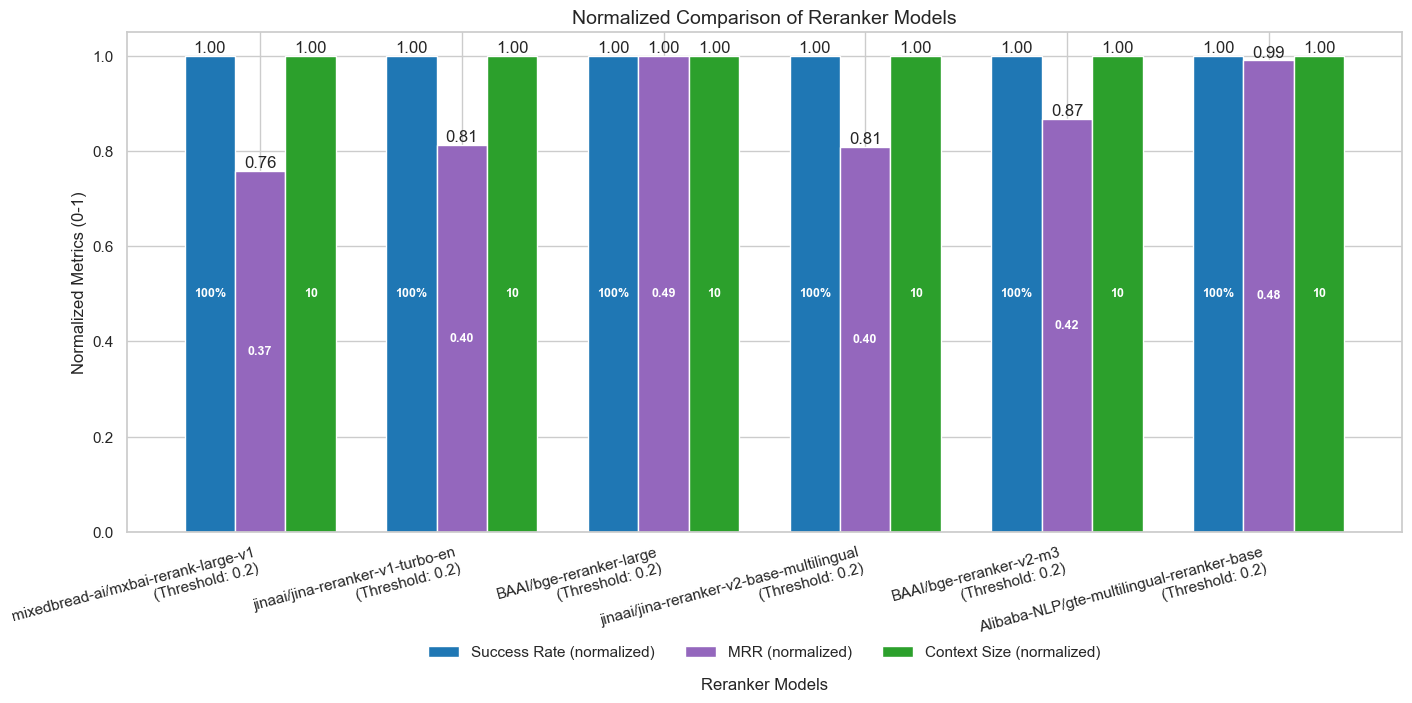

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = reranker_models
best_thresholds = best_thresholds
success_rates = success_rates  # Without metadata at their respective thresholds
max_context_sizes = max_total_context_size  # Without metadata
mrr_scores = avg_rerank_mrr  # Without metadata

# Normalize all metrics to a 0-1 range
max_success_rate = max(success_rates)
max_mrr = max(mrr_scores)
min_context_size = min(max_context_sizes)  # Use min for inversion

normalized_success_rates = [rate / max_success_rate for rate in success_rates]
normalized_mrr_scores = [mrr / max_mrr for mrr in mrr_scores]
normalized_context_sizes = [
    min_context_size / size if size != 0 else 0 for size in max_context_sizes
]  # Invert for smaller-is-better

# Bar plot configurations
bar_width = 0.25
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(14, 7))

# Bars for normalized metrics
bars1 = ax.bar(
    x - bar_width,
    normalized_success_rates,
    width=bar_width,
    label="Success Rate (normalized)",
    color="#1f77b4",
)
bars2 = ax.bar(
    x,
    normalized_mrr_scores,
    width=bar_width,
    label="MRR (normalized)",
    color="#9467bd"
)
bars3 = ax.bar(
    x + bar_width,
    normalized_context_sizes,
    width=bar_width,
    label="Context Size (normalized)",
    color="#2ca02c",
)

# Add normalized text labels above bars
for bars, data in zip(
    [bars1, bars2, bars3],
    [normalized_success_rates, normalized_mrr_scores, normalized_context_sizes],
):
    for bar, value in zip(bars, data):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{value:.2f}",
            ha="center",
            va="bottom",
        )

# Add non-normalized text labels in the middle of bars
for bars, original_data in zip(
    [bars1, bars2, bars3],
    [success_rates, mrr_scores, max_context_sizes],
):
    for bar, orig in zip(bars, original_data):
        height = bar.get_height()
        if bars is bars1:
            label = f"{orig * 100:.0f}%"
        elif bars is bars2:
            label = f"{orig:.2f}"
        else:
            label = f"{orig}"
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height / 2,
            label,
            ha="center",
            va="center",
            color='white',
            fontsize=9,
            fontweight='bold'
        )

# Customization
labels = [f"{model}\n(Threshold: {threshold})" for model, threshold in zip(models, best_thresholds)]
ax.set_xlabel("Reranker Models", fontsize=12)
ax.set_ylabel("Normalized Metrics (0-1)", fontsize=12)
ax.set_title("Normalized Comparison of Reranker Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.xaxis.labelpad = 20
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    frameon=False,
)

plt.tight_layout()
plt.xticks(rotation=15, ha="right")
plt.show()


### One Threshold Value


In [18]:
best_threshold = 0.2

Best threshold: 0.2
Data filtered to threshold=0.2, rows=1146


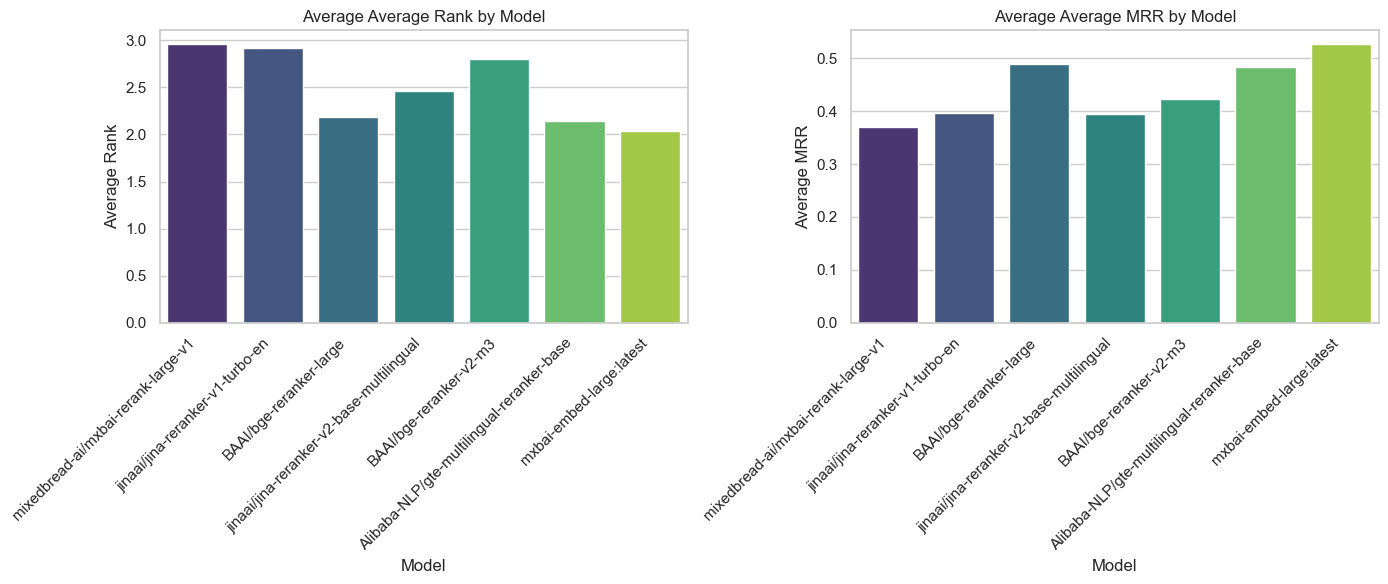


=== Mean Rank and MRR by Model ===
                                     Model  Average Rank  Average MRR
       mixedbread-ai/mxbai-rerank-large-v1      2.958115     0.370635
          jinaai/jina-reranker-v1-turbo-en      2.916230     0.397322
                   BAAI/bge-reranker-large      2.188482     0.488752
 jinaai/jina-reranker-v2-base-multilingual      2.465969     0.395165
                   BAAI/bge-reranker-v2-m3      2.806283     0.423749
Alibaba-NLP/gte-multilingual-reranker-base      2.146597     0.484214
                  mxbai-embed-large:latest      2.031414     0.526488
- Lower Average Rank and higher Average MRR indicate better performance.



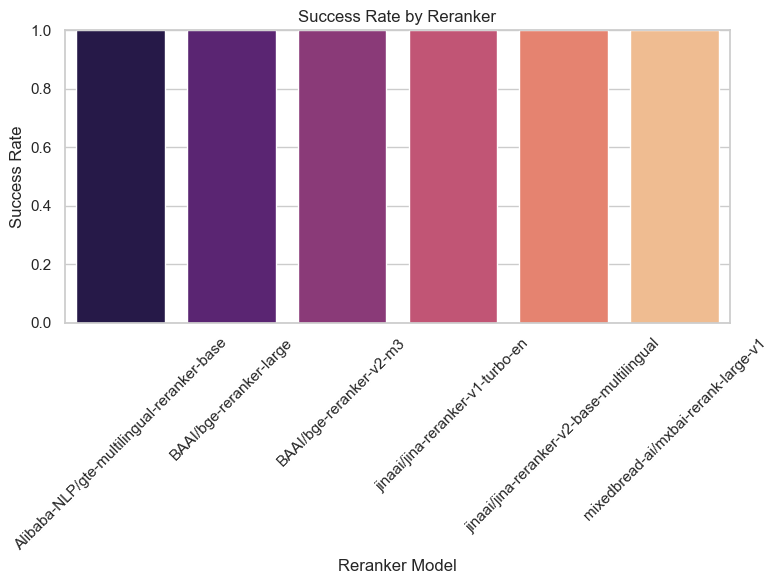


=== Success Rate of Finding Expected Chunks ===
                            reranker_model  Success Rate (%)
Alibaba-NLP/gte-multilingual-reranker-base             100.0
                   BAAI/bge-reranker-large             100.0
                   BAAI/bge-reranker-v2-m3             100.0
          jinaai/jina-reranker-v1-turbo-en             100.0
 jinaai/jina-reranker-v2-base-multilingual             100.0
       mixedbread-ai/mxbai-rerank-large-v1             100.0
- Higher percentages mean better retrieval.



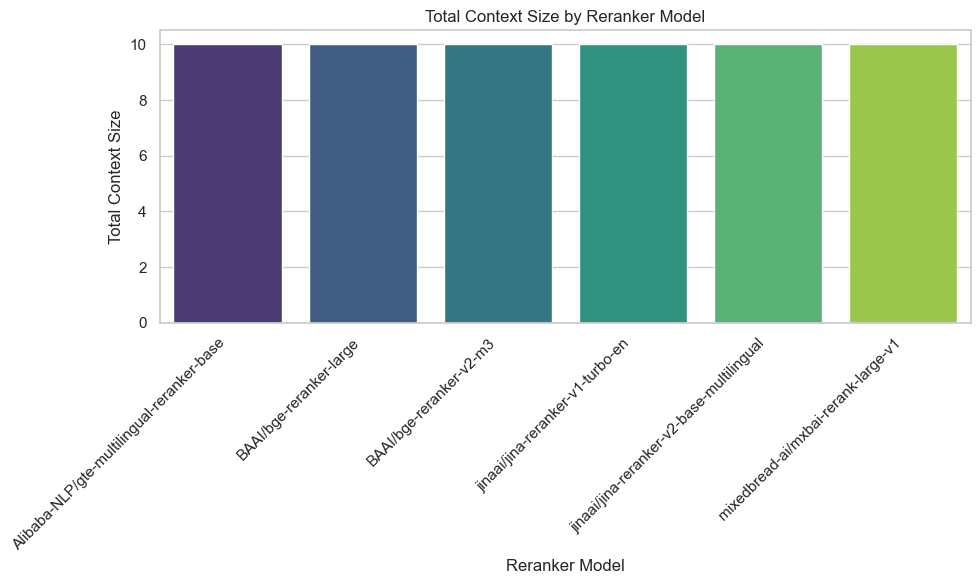


=== Total Context Size by Model ===
                            reranker_model  total_context_size
Alibaba-NLP/gte-multilingual-reranker-base                  10
                   BAAI/bge-reranker-large                  10
                   BAAI/bge-reranker-v2-m3                  10
          jinaai/jina-reranker-v1-turbo-en                  10
 jinaai/jina-reranker-v2-base-multilingual                  10
       mixedbread-ai/mxbai-rerank-large-v1                  10
- Lower Total Context Size is better.



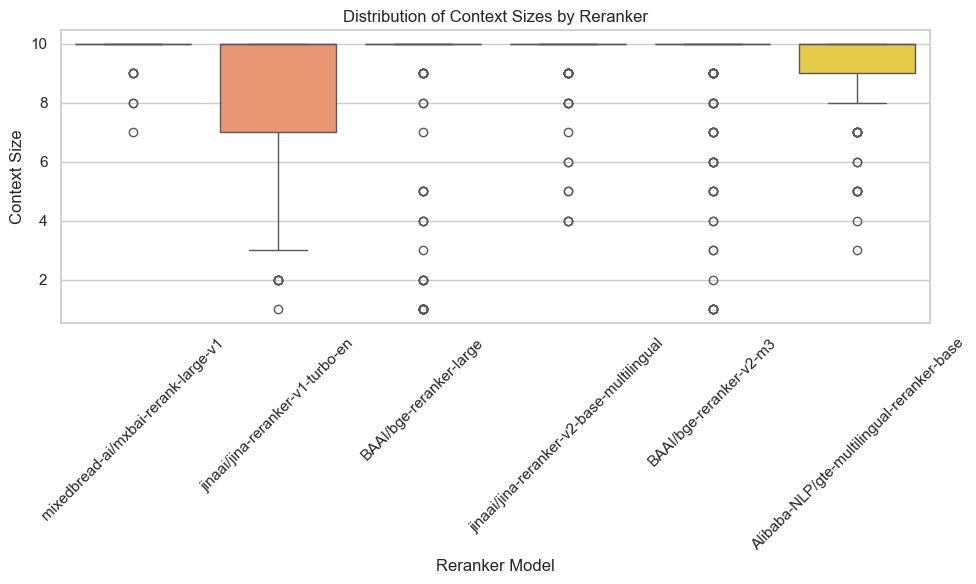


=== Context Size Distribution ===
                            reranker_model  count     mean      std  min  25%  50%  75%  max
Alibaba-NLP/gte-multilingual-reranker-base  191.0 9.198953 1.274114  3.0  9.0 10.0 10.0 10.0
                   BAAI/bge-reranker-large  191.0 8.680628 2.942894  1.0 10.0 10.0 10.0 10.0
                   BAAI/bge-reranker-v2-m3  191.0 9.136126 2.095686  1.0 10.0 10.0 10.0 10.0
          jinaai/jina-reranker-v1-turbo-en  191.0 8.261780 2.391774  1.0  7.0 10.0 10.0 10.0
 jinaai/jina-reranker-v2-base-multilingual  191.0 9.701571 1.046270  4.0 10.0 10.0 10.0 10.0
       mixedbread-ai/mxbai-rerank-large-v1  191.0 9.942408 0.327402  7.0 10.0 10.0 10.0 10.0
- Shows how many chunks each reranker typically uses.



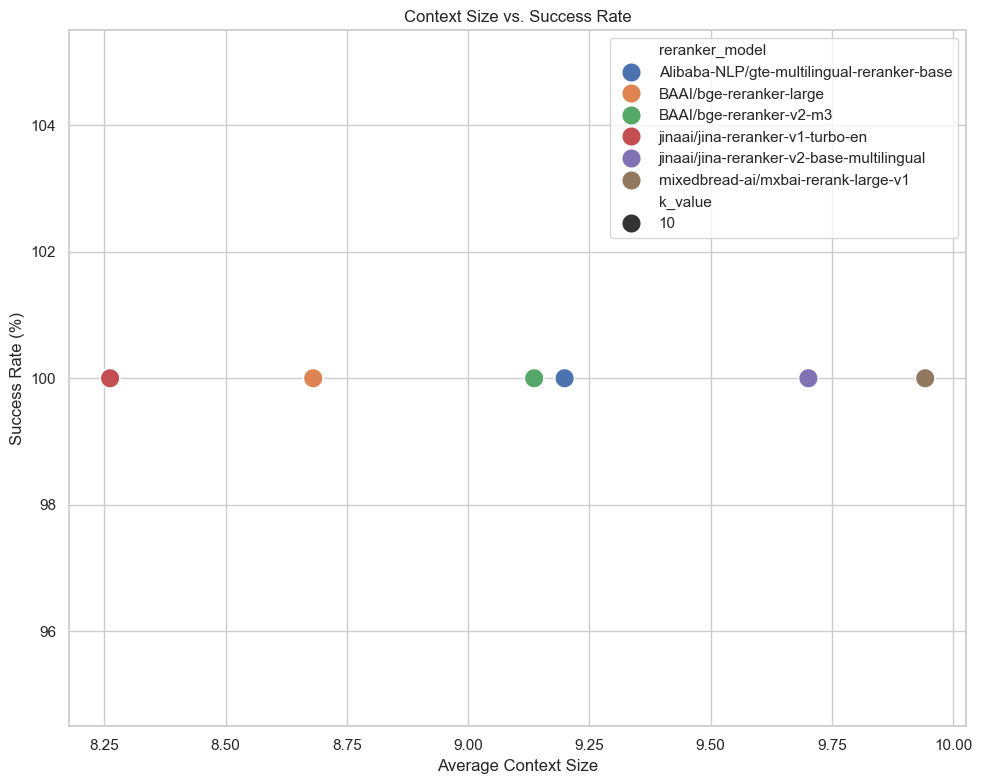


=== Relationship between Context Size and Success Rate ===
Pearson Correlation: nan
- Positive correlation suggests larger context could improve success, but also may be costlier.



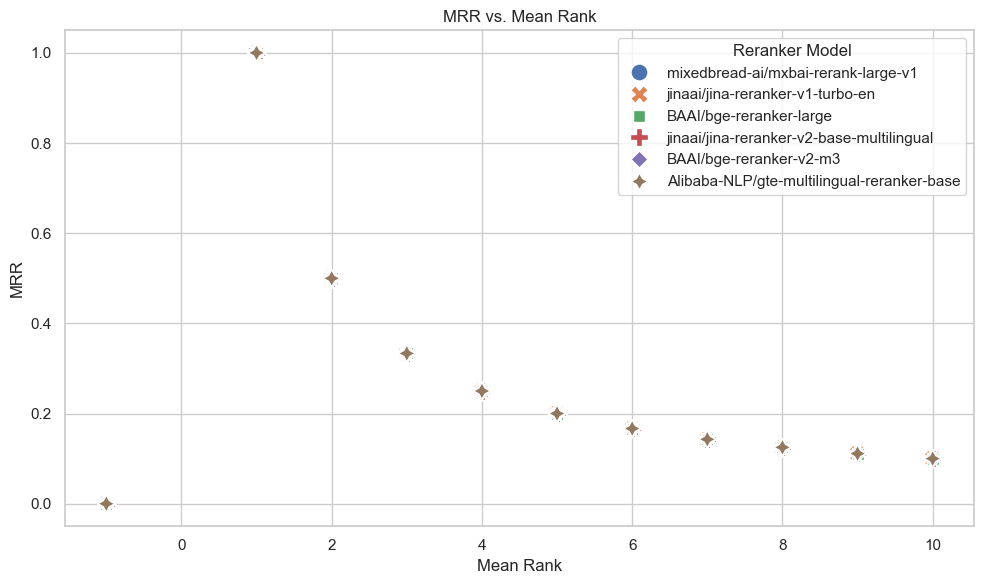


=== MRR vs. Mean Rank ===
Overall Pearson Correlation: -0.24
- Lower mean_rank and higher mrr usually indicate stronger performance.



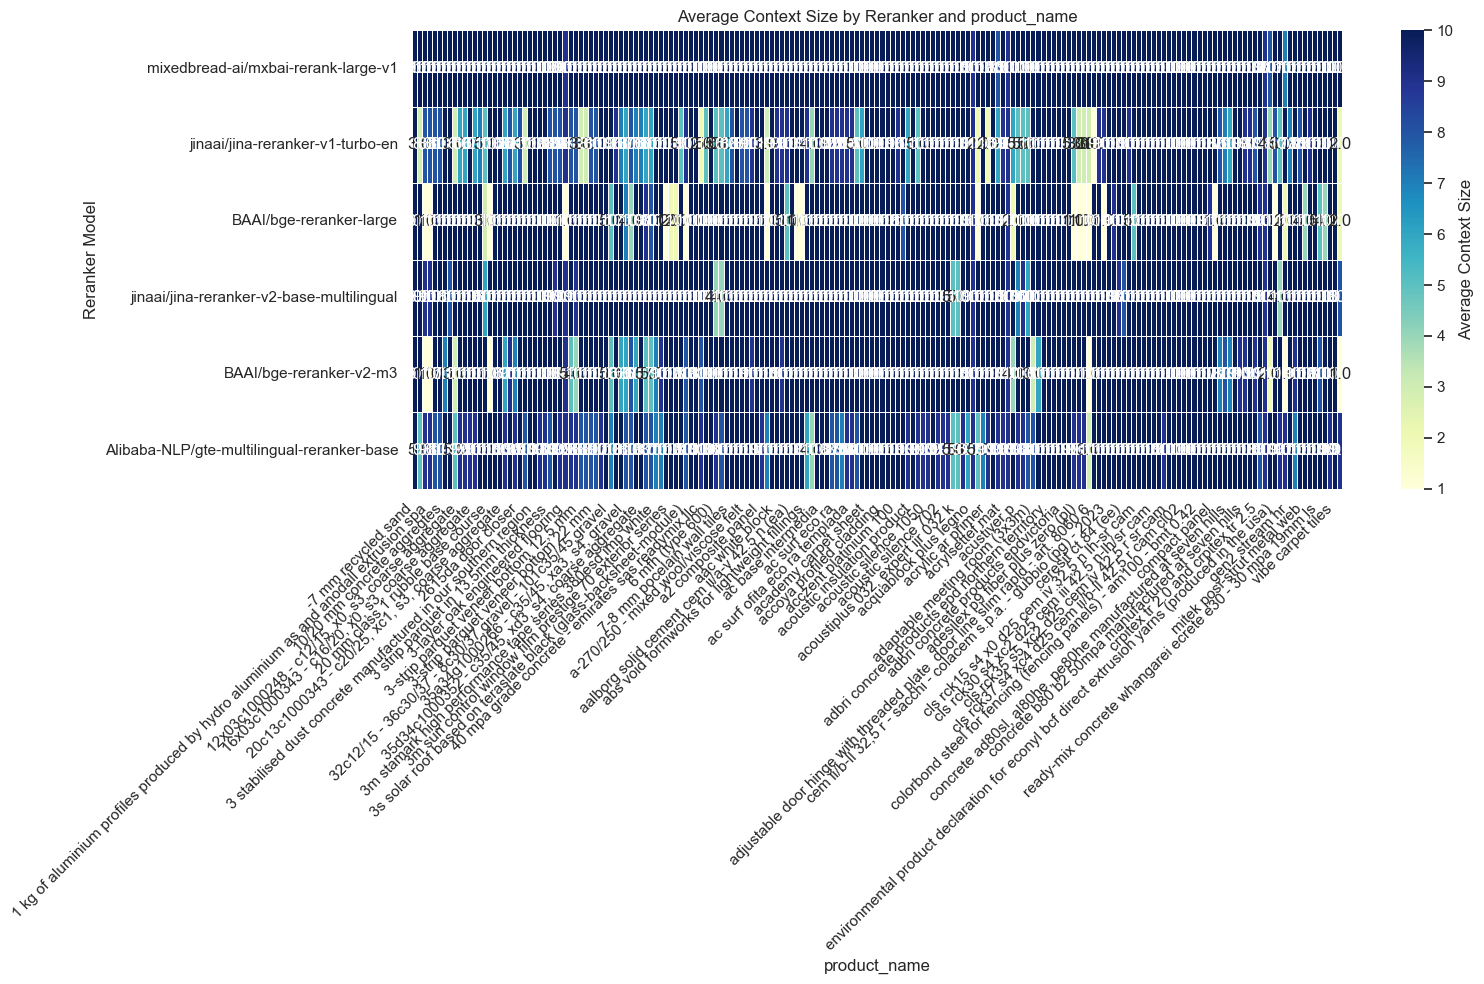


=== Heatmap - Average Context Size by product_name ===
product_name                                -7 mm recycled sand  00005s000j343 - screed  1 kg of aluminium profiles produced by fonderie pandolfo spa and anodall extrusion spa  1 kg of aluminium profiles produced by hydro aluminium as and anodall extrusion spa  1 strip parquet in 13.5mm thickness  1-strip parquet veneer bottom 13,5-14 mm  10/20 mm concrete aggregtes  10/20 mm drainage aggregates  12.5 mm rigips habito  12x03c1000248 - c12/15, x0, s3, coarse aggregate  12x03c1000343 - c12/15, x0, s3, coarse aggregate  15 mm gyproc duraline  16x03c1000343 - c16/20, x0, s3, coarse aggregate  1m of billiemi bottarga grey marble slab, from the bordonaro quarry, 2 cm thick, sandblasted or polished, produced by so.f.i.l. srl  1m2 of expanded polystyrene (eps) insulation boards  20 mm class 1 rubble base course  20 mm class 2 rubble sub base  20 mm porcelain tiles  20c13c1000343 - c20/25, xc1, s3, coarse aggregate  20c14g1001051 - c20/25,

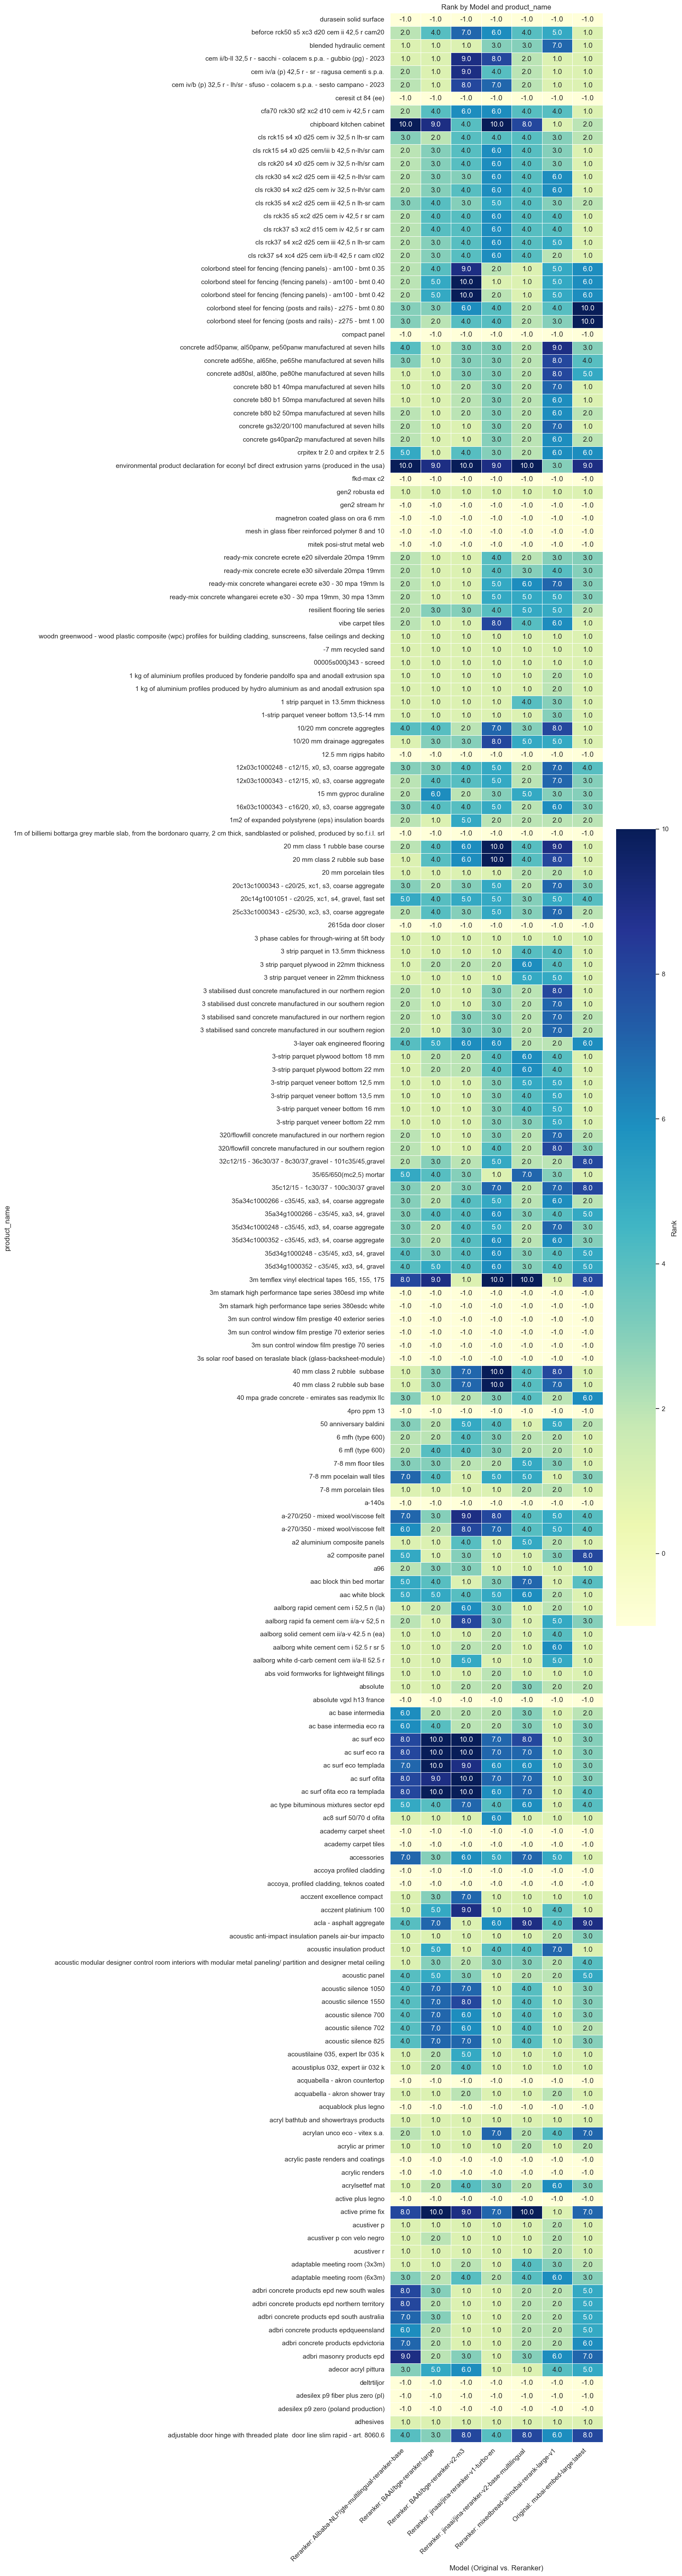


=== Heatmap Data ===
Combined_Model                                                                                                                       Reranker: Alibaba-NLP/gte-multilingual-reranker-base  Reranker: BAAI/bge-reranker-large  Reranker: BAAI/bge-reranker-v2-m3  Reranker: jinaai/jina-reranker-v1-turbo-en  Reranker: jinaai/jina-reranker-v2-base-multilingual  Reranker: mixedbread-ai/mxbai-rerank-large-v1  Original: mxbai-embed-large:latest
product_name                                                                                                                                                                                                                                                                                                                                                                                                                                       
durasein solid surface                                                                                    

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ======================
# 2. DATA PREPARATION
# ======================
df["context_contains_expected"] = df["context_contains_expected"].astype(bool)
numeric_cols = [
    "rank",
    "rerank_rank",
    "mean_rank",
    "mrr",
    "rerank_mrr",
    "context_added",
    "context_threshold",
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(-1)

# If -1 is used for missing rank or threshold, you might want to handle that explicitly
df["mrr"] = df["mrr"].replace(-1, 0.0)
df["rerank_mrr"] = df["rerank_mrr"].replace(-1, 0.0)
df["context_added"] = df["context_added"].replace(-1, 0.0)
df["context_threshold"] = df["context_threshold"].replace(-1, 0.0)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.max_open_warning": 0})


# ==========================
# 3. DETERMINE BEST THRESHOLD
# ==========================
# def find_best_threshold(df):
#     """
#     Example logic: find the threshold with highest overall success rate across all reranker models.
#     Returns a single float (the 'best' threshold).
#     """
#     # Group by threshold, compute overall success rate
#     # grp = df.groupby("context_threshold")["context_contains_expected"].mean()
#     # best_threshold = grp.idxmax()  # threshold with highest success rate
#     best_threshold = 0.2  # threshold with highest success rate
#     return best_threshold

# best_threshold = find_best_threshold(df)
# print(f"Best Threshold identified: {best_threshold}")

# # Filter data by best threshold
# filtered_df = df[df["context_threshold"] == best_threshold].copy()


# ==========================
# 4. VISUALIZATION FUNCTIONS
# ==========================
def plot_mean_rank_and_mrr(df):
    """Bar plots for average rank and MRR by all models, without differentiating model types."""
    # Prepare Embedding Models DataFrame
    embedding_df = df[["model", "rank", "mrr"]].rename(
        columns={
            "model": "Model",
            "rank": "Average Rank",
            "mrr": "Average MRR",
        }
    )

    # Prepare Reranker Models DataFrame
    reranker_df = df[["reranker_model", "rerank_rank", "rerank_mrr"]].rename(
        columns={
            "reranker_model": "Model",
            "rerank_rank": "Average Rank",
            "rerank_mrr": "Average MRR",
        }
    )

    # Combine both DataFrames
    combined_df = pd.concat([embedding_df, reranker_df], ignore_index=True)

    # Aggregate by Model
    agg_df = (
        combined_df.groupby("Model")
        .agg({"Average Rank": "mean", "Average MRR": "mean"})
        .reset_index()
    )

    # Define Desired Model Order
    models = df["model"].unique()
    reranker_models = df["reranker_model"].unique()
    model_order = list(reranker_models) + list(models)

    # Reorder Models
    agg_df["Model"] = pd.Categorical(
        agg_df["Model"], categories=model_order, ordered=True
    )
    agg_df = agg_df.sort_values("Model")

    # Plotting
    plt.figure(figsize=(14, 6))
    for i, metric in enumerate(["Average Rank", "Average MRR"], 1):
        plt.subplot(1, 2, i)
        sns.barplot(data=agg_df, x="Model", y=metric, hue="Model", palette="viridis")
        plt.title(f"Average {metric} by Model")
        plt.xlabel("Model")
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
    plt.show()

    # Textual Representation
    print("\n=== Mean Rank and MRR by Model ===")
    print(agg_df.to_string(index=False))
    print("- Lower Average Rank and higher Average MRR indicate better performance.\n")


def plot_context_added_boxplot(df):
    """Box plot for context_added by reranker_model, plus textual representation."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df,
        x="reranker_model",
        y="context_added",
        hue="reranker_model",
        palette="Set2",
    )
    plt.title("Distribution of Context Sizes by Reranker")
    plt.xlabel("Reranker Model")
    plt.ylabel("Context Size")
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

    print("\n=== Context Size Distribution ===")
    stats = df.groupby("reranker_model")["context_added"].describe().reset_index()
    print(stats.to_string(index=False))
    print("- Shows how many chunks each reranker typically uses.\n")


def plot_success_rate(df):
    success_rate = (
        df.groupby("reranker_model")["context_contains_expected"].mean().reset_index()
    )
    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=success_rate,
        x="reranker_model",
        y="context_contains_expected",
        hue="reranker_model",
        palette="magma",
    )
    plt.title("Success Rate by Reranker")
    plt.xlabel("Reranker Model")
    plt.ylabel("Success Rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

    print("\n=== Success Rate of Finding Expected Chunks ===")
    success_rate["Success Rate (%)"] = success_rate["context_contains_expected"] * 100
    success_rate = success_rate.drop(columns=["context_contains_expected"])
    print(success_rate.to_string(index=False))
    print("- Higher percentages mean better retrieval.\n")


def plot_context_vs_success(df):
    summary_corr = (
        df.groupby(["reranker_model", "k_value"])
        .agg({"context_added": "mean", "context_contains_expected": "mean"})
        .reset_index()
    )
    summary_corr["Success Rate (%)"] = summary_corr["context_contains_expected"] * 100

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=summary_corr,
        x="context_added",
        y="Success Rate (%)",
        hue="reranker_model",
        style="k_value",
        s=200,
        palette="deep",
    )
    plt.title("Context Size vs. Success Rate")
    plt.xlabel("Average Context Size")
    plt.ylabel("Success Rate (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n=== Relationship between Context Size and Success Rate ===")
    corr_value = summary_corr[["context_added", "Success Rate (%)"]].corr().iloc[0, 1]
    print(f"Pearson Correlation: {corr_value:.2f}")
    print(
        "- Positive correlation suggests larger context could improve success, but also may be costlier.\n"
    )


def plot_mrr_vs_mean_rank(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x="mean_rank",
        y="mrr",
        hue="reranker_model",
        style="reranker_model",
        s=150,
    )
    plt.title("MRR vs. Mean Rank")
    plt.xlabel("Mean Rank")
    plt.ylabel("MRR")
    plt.legend(title="Reranker Model")
    plt.tight_layout()
    plt.show()

    print("\n=== MRR vs. Mean Rank ===")
    corr_value = df[["mean_rank", "mrr"]].corr().iloc[0, 1]
    print(f"Overall Pearson Correlation: {corr_value:.2f}")
    print("- Lower mean_rank and higher mrr usually indicate stronger performance.\n")


def plot_heatmap_context_added(df):
    heat_data = (
        df.groupby(["reranker_model", "product_name"])["context_added"].mean().unstack()
    )
    reranker_models = df["reranker_model"].unique()
    model_order = list(reranker_models)
    heat_data = heat_data.reindex(model_order)
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        heat_data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Average Context Size"},
    )
    plt.title("Average Context Size by Reranker and product_name")
    plt.xlabel("product_name")
    plt.ylabel("Reranker Model")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, ha="right")
    plt.tight_layout()
    plt.show()

    print("\n=== Heatmap - Average Context Size by product_name ===")
    print(heat_data.round(1).fillna("N/A").to_string())
    print("- Helps compare chunk usage across different product_names.\n")

def plot_heatmap_rank(df):
    # Prepare original model data with an identifier
    original_rank_df = df[["model", "product_name", "rank"]].rename(
        columns={"model": "Model", "rank": "Rank"}
    )
    original_rank_df["Combined_Model"] = "Original: " + original_rank_df["Model"].astype(str)
    
    # Prepare reranker model data with an identifier
    rerank_rank_df = df[["reranker_model", "product_name", "rerank_rank"]].rename(
        columns={"reranker_model": "Model", "rerank_rank": "Rank"}
    )
    rerank_rank_df["Combined_Model"] = "Reranker: " + rerank_rank_df["Model"].astype(str)
    
    # Combine the dataframes
    combined_df = pd.concat([original_rank_df, rerank_rank_df], ignore_index=True)
    combined_df = combined_df.groupby(["Combined_Model", "product_name"])["Rank"].mean().reset_index()
    
    # Pivot the data: product_name on y-axis and Combined_Model on x-axis
    pivot_data = combined_df.pivot(index="product_name", columns="Combined_Model", values="Rank")
    
    # Preserve product_name order as it appears in the CSV
    product_order = df["product_name"].unique()
    pivot_data = pivot_data.reindex(product_order)
    
    # Optional: Reorder columns if desired (e.g., reranker models first)
    combined_order = sorted(pivot_data.columns, key=lambda x: 0 if x.startswith("Reranker:") else 1)
    pivot_data = pivot_data[combined_order]
    
    # Plot the heatmap
    plt.figure(figsize=(16, 60))
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Rank"},
    )
    plt.title("Rank by Model and product_name")
    plt.xlabel("Model (Original vs. Reranker)")
    plt.ylabel("product_name")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, ha="right")
    plt.tight_layout()
    plt.show()
    
    # Print the pivot data for reference
    print("\n=== Heatmap Data ===")
    print(pivot_data.fillna("N/A").round(1).to_string())
    print("- Lower ranks suggest better positioning for the expected result.\n")



def plot_total_context_size_bar(df):
    """Bar chart comparing total_context_size of every model."""
    agg_df = df.groupby("reranker_model")["total_context_size"].max().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=agg_df,
        x="reranker_model",
        y="total_context_size",
        hue="reranker_model",
        palette="viridis",
    )
    plt.title("Total Context Size by Reranker Model")
    plt.xlabel("Reranker Model")
    plt.ylabel("Total Context Size")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print("\n=== Total Context Size by Model ===")
    print(agg_df.to_string(index=False))
    print("- Lower Total Context Size is better.\n")


# ==========================
# 5. COMPREHENSIVE SUMMARY
# ==========================
def generate_comprehensive_summary(df):
    summary = (
        df.groupby("reranker_model")
        .agg(
            context_contains_expected=("context_contains_expected", "mean"),
            context_added=("context_added", "mean"),
            mrr=("mrr", "mean"),
            rerank_mrr=("rerank_mrr", "mean"),
            mean_rank=("mean_rank", "mean"),
            rank=("rank", "mean"),
            rerank_rank=("rerank_rank", "mean"),
            product_names=("product_name", "nunique"),
            max_total_context_size=("total_context_size", "max"),
        )
        .reset_index()
    )

    summary["Success_Rate_(%)"] = summary["context_contains_expected"] * 100
    summary = summary.drop(columns=["context_contains_expected"])

    summary = summary.rename(
        columns={
            "context_added": "Average_Context_Added",
            "mrr": "Average_MRR",
            "rerank_mrr": "Average_Rerank_MRR",
            "mean_rank": "Average_Mean_Rank",
            "rank": "Average_Original_Rank",
            "rerank_rank": "Average_Rerank",
            "product_names": "Total_Product_Names",
            "max_total_context_size": "Max_Total_Context_Size",
        }
    )

    summary = summary[
        [
            "reranker_model",
            "Success_Rate_(%)",
            "Average_Context_Added",
            "Average_MRR",
            "Average_Rerank_MRR",
            "Average_Mean_Rank",
            "Average_Original_Rank",
            "Average_Rerank",
            "Total_Product_Names",
            "Max_Total_Context_Size",
        ]
    ]
    return summary


def print_comprehensive_summary(df):
    summary_df = generate_comprehensive_summary(df)
    print("\n=== COMPREHENSIVE SUMMARY ===")
    print(summary_df.to_string(index=False))
    print("")


# ======================================
# 6. MAIN: APPLY BEST THRESHOLD & PLOTS
# ======================================

# 1) Identify & filter on best threshold
filtered_df = df[df["context_threshold"] == best_threshold].copy()

print(f"Best threshold: {best_threshold}")
print(f"Data filtered to threshold={best_threshold}, rows={len(filtered_df)}")

# 2) Pass the filtered DataFrame to the original plots
plot_mean_rank_and_mrr(filtered_df)
plot_success_rate(filtered_df)
plot_total_context_size_bar(filtered_df)
plot_context_added_boxplot(filtered_df)
plot_context_vs_success(filtered_df)
plot_mrr_vs_mean_rank(filtered_df)
plot_heatmap_context_added(filtered_df)
plot_heatmap_rank(filtered_df)
print_comprehensive_summary(filtered_df)